In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path


import image_processing as ip

#for the next line to work, the file create_example_for_grid_stitching.py
#should be in the same directory as this notebook
import create_example_for_grid_stitching

create_example_for_grid_stitching.run_script()

# Load Files

In [2]:
genpath = "./"

#first number of rows of images,
#second number of columns of images
tile_dimensions=[5,5]

#relative image overlap
#first number corresponds vertically to rows of pixels overlapping
#second number should give the amount of columns overlapping
expected_overlap=[0.25,0.25] 

In [3]:
#get a list of the file-pathes sorted by date
pathlist = sorted(Path(genpath).iterdir(), key=os.path.getmtime)
for i in range(len(pathlist)):
    pathlist[i]=str(pathlist[i])
paths=np.array(pathlist)

In [4]:
# choose only .tif -files
desired_format='tif'
format_list=[]

for i in range(len(pathlist)):
    if str(pathlist[i])[-3:] == desired_format:
        format_list.append(True)
    else:
        format_list.append(False)
        
pathlist=paths[format_list]

In [5]:
print(pathlist)

['image_0.tif' 'image_1.tif' 'image_2.tif' 'image_3.tif' 'image_4.tif'
 'image_5.tif' 'image_6.tif' 'image_7.tif' 'image_8.tif' 'image_9.tif'
 'image_10.tif' 'image_11.tif' 'image_12.tif' 'image_13.tif'
 'image_14.tif' 'image_15.tif' 'image_16.tif' 'image_17.tif'
 'image_18.tif' 'image_19.tif' 'image_20.tif' 'image_21.tif'
 'image_22.tif' 'image_23.tif']


In [6]:
# load images and reduce noise and data-size by rebinning 
# optional step, but often useful, as the result is the montage of all 
# images, which can lead to very big filesizes

rebin = 2

images_orig = []

done = []
for path in pathlist:
    image = cv2.imread(path,0)
    newshape = image.shape[0]//rebin, rebin, image.shape[1]//rebin, rebin
    image = image.reshape(newshape).mean((1,3)).astype(np.uint8)
    images_orig.append(image)

In [7]:
# images_orig should be a list of images as a series of rows from top to bottom 
# and within the row from left to right
# missing files at the end of the series (in the last row of the montage) are acceptable

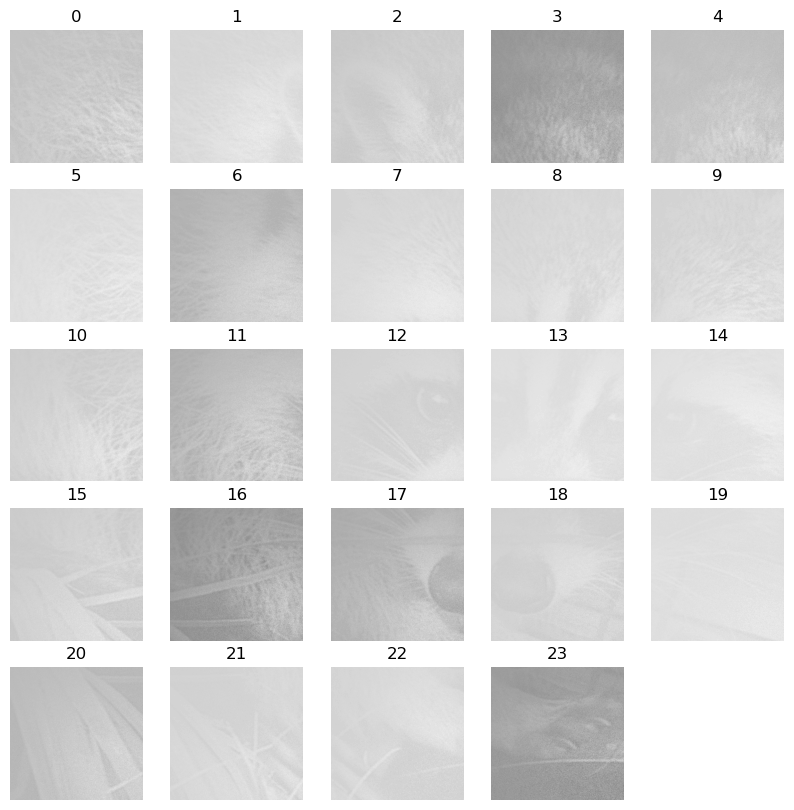

In [8]:
#first look at the images (of course, works only for a small number of images)
fig, ax = plt.subplots(tile_dimensions[0], tile_dimensions[1], figsize=(tile_dimensions[0]*2, tile_dimensions[1]*2))
ax = ax.ravel()
for i in range(len(ax)):
    if i < len(images_orig):
        image = images_orig[i] 
        ax[i].set_title(i)
        ax[i].imshow(image, cmap="gray",vmin=0,vmax=255)
        
    ax[i].axis('off')
    

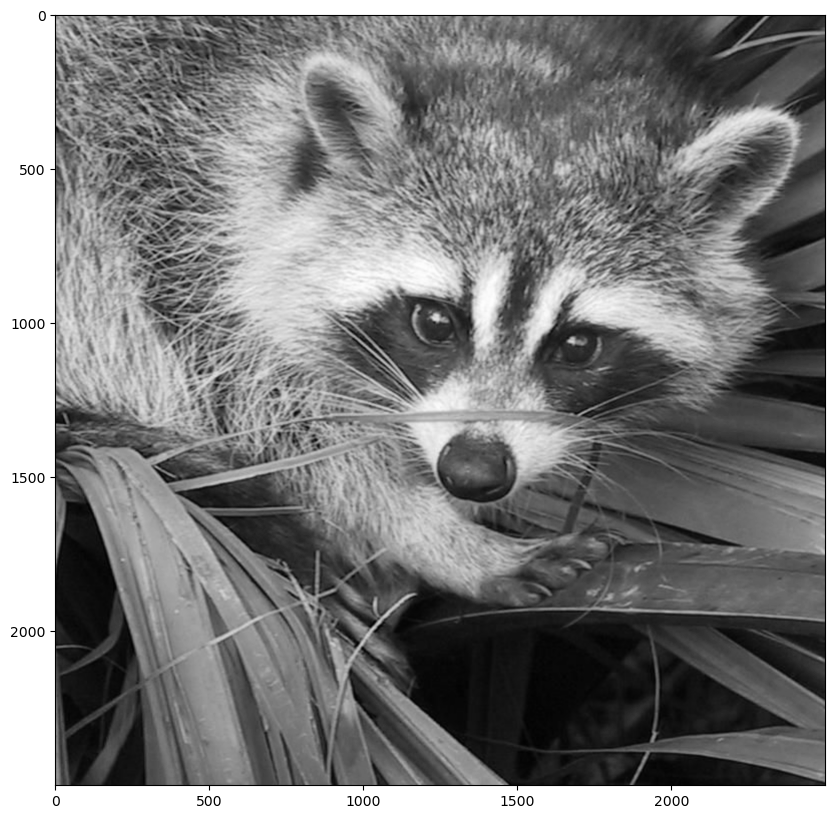

In [9]:
# comparison to original to see also the noise level
orig=cv2.imread("background_without_noise.png",0)
plt.figure(figsize=[10,10])
plt.imshow(orig,cmap='gray')
plt.show()

# Execution of the Stitching

In [10]:
#To achieve homogeneous brightness at non-optimal lightning, 
#the images are normalized (divided by) mask, a blurred median-image of the series
#mask is also returned for weighting areas differently so, 
#when later overlapping image-regions are summed, mask ensures that
#the influence of a well illuminated area is bigger, than a poorly illuminated area.
images,immed,madnorm,mask=ip.optimize_images(images_orig)
#The median-image and the median-absolute-distance-image are returned just in case of inspection

In [11]:
#Normalize the brightness of all pictures in the series, by multiplying each image
#with a factor, so that the maximum of the pixelvalue-histogram of every image is
#at the same position.
images=ip.contrast_correction(images)

In [12]:
#images=images_orig

In [13]:
#Starting with a relatively high tolerance (default 10%), relative image-stitching positions are calculated from
#the maximum of the phase-correlation-matrix between two images.
#From the two stitching-processses, once horizontally and once vertically, with maximal similarity in the overlap-region
#the difference to the expected overlap is calculated and returned as drift-values.
drifts,alldrifts_r,alldrifts_d=ip.drift_correction(images,tile_dimensions,[0.25,0.25],tolerance=0.1)
#The first tuple of drifts corresponds to drift occuring at horizontal moves, the second tuple corresponds to vertical moves.

#ignore_montage_edges is a percentage of how much of the outermost images of the monatge-series should be ignored, 
#for example in case part of the montage covers areas outside the region of interest
print(drifts)

#drifts=[[0,0],[0,0]]

[array([3. , 3.5]), array([-14.5,   0. ])]


In [14]:
#Now accounting for constant drift usually a tolerance between 5% down to 0.5% can be achieved.
#Relative positions between images are determined from each image to its right and bottom neighbour.
#The relative position is calculated by the maximum of the phase-correlation-matrix within the given region
#of possible positions limited by the drift and tolerance
positions,neighbours,pos_pcms=ip.relative_stitching_positions(images,tile_dimensions,overlap_rows_cols=expected_overlap,
                                                              tolerance=0.05,ignore_montage_edges=0.,drifts=drifts)
#pos_pcms is the value of the maximum of the phase-correlation-matrix giving a measure of the similarity in the overlap-region.

In [15]:
#By obtaining the relative distances between images for right and bottom neighbours and starting in the top left corner, 
#in general all other pictures can be positioned either corresponding to its left or top neighbour.
#In case these two positions are not the same, conftlict_sol="last" only uses the position given by the left neighbour and 
#only for the first image of the row the distance to its top neighbour is used. "average" takes the sum divided by two of 
#the two possible positions and "weighted" takes a sum of the positions weighted by the similarity of the overlap region, 
#which is the recommended mode.
absolute_positions=ip.absolute_stitching_positions(positions,neighbours,tile_dimensions,pos_pcms,conflict_sol='weighted')

In [16]:
#stitching is done by fading out one picture and fading in the next picture in the overlap-region, 
#where mask defines the fading. In contrast to sharp cutting and gluing the pictures,
#this method allows to quickly see the quality of the stitching, by looking at the sharpness
#of the resulting montage-image in the overlap-regions (which is blurry or even showing doubles in bad cases)
montage=ip.stitch_grid(images,absolute_positions,tile_dimensions,mask)

# Optimizing the resulting montage

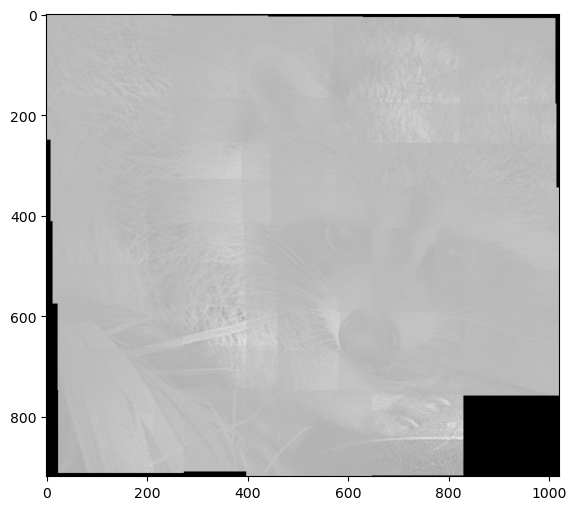

In [17]:
%matplotlib inline
plt.figure(figsize=[9,6])
plt.imshow(montage,cmap='gray')
plt.show()

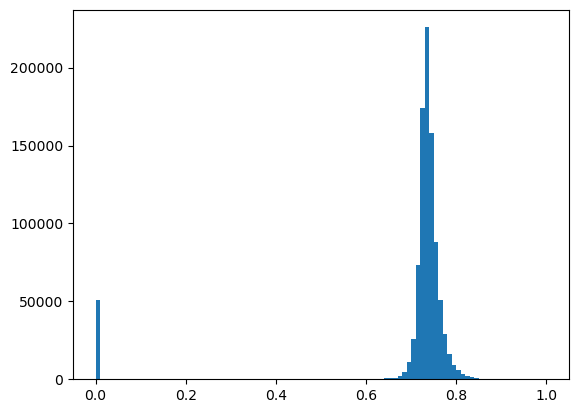

In [18]:
%matplotlib inline
#look at the brightness histogram to adjust contrast
mflat=np.reshape(montage,montage.shape[0]*montage.shape[1])
plt.hist(mflat,100)
plt.show()

In [19]:
#choose suiting clipping values for better contrast and brightness
clipmin=0.6
clipmax=0.9
newmon=(np.clip(montage,clipmin,clipmax)/clipmax *255)

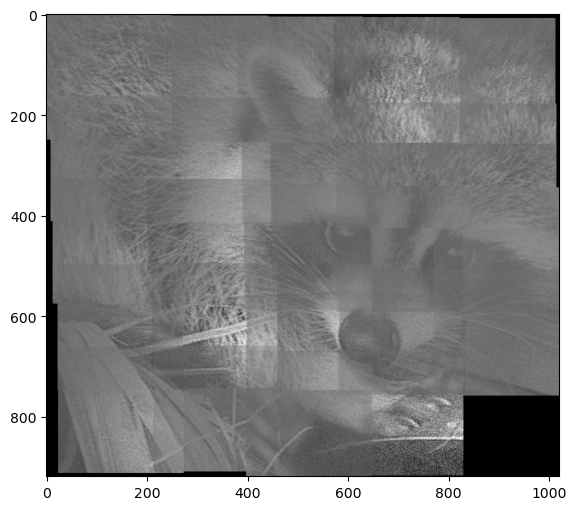

In [20]:
%matplotlib inline
#show final result
plt.figure(figsize=[9,6])
plt.imshow(newmon,cmap='gray')